In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 128

DATA_DIR = '/content/drive/MyDrive/PR_hw5/data'
CKPT_DIR = '/content/drive/MyDrive/PR_hw5/checkpoints'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [ ]:
# Datasets path
x_train_data_path = f'{DATA_DIR}/x_train.npy'
y_train_data_path = f'{DATA_DIR}/y_train.npy'
x_test_data_path = f'{DATA_DIR}/x_test.npy'
y_test_data_path = f'{DATA_DIR}/y_test.npy'


In [ ]:
class_index = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}


# ResNet and Residual Block

In [ ]:
class ResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, width, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, width * self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(width * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class ResNet(nn.Module):
    def __init__(self, layer_cnts, class_cnt):
        super().__init__()
        self.block_in_channels = 64
        self.conv1 = nn.Conv2d(3, self.block_in_channels, kernel_size=7,
                               stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(self.block_in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, layer_cnts[0])
        self.layer2 = self._make_layer(128, layer_cnts[1], stride=2)
        self.layer3 = self._make_layer(256, layer_cnts[2], stride=2)
        self.layer4 = self._make_layer(512, layer_cnts[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResidualBlock.expansion, class_cnt)
        self.activation = nn.Softmax(dim=1)

    def _make_layer(self, channels, block_cnt, stride=1):
        # This function creates block_cnt of Residual Blocks equentially

        # Create down sample layer
        # Down sample is necessary if size of the blocks are not the same
        downsample = None
        if (stride != 1 or
                self.block_in_channels != channels * ResidualBlock.expansion):
            downsample = nn.Sequential(
                nn.Conv2d(self.block_in_channels,
                          channels * ResidualBlock.expansion,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(channels * ResidualBlock.expansion)
            )

        # Create the first Residual Block with down sample layers
        layers = []
        layers.append(
            ResidualBlock(in_channels=self.block_in_channels, width=channels,
                          stride=stride, downsample=downsample)
        )

        # Create the rest Residual Blocks
        self.block_in_channels = channels * ResidualBlock.expansion
        for _ in range(1, block_cnt):
            layers.append(
                ResidualBlock(in_channels=self.block_in_channels,
                              width=channels)
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.activation(x)

        return x

    def predict(self, x_test):
        # This function feeds original test images and flipped
        # test images to the network and returns predictions according to
        # the max network outputs
        with torch.no_grad():
            outputs = self(x_test)

            x_test_flipped = torch.flip(x_test, [3])
            outputs_flipped = net(x_test_flipped)

            outputs += outputs_flipped

            _, predictions = torch.max(outputs, 1)

            return predictions.cpu().numpy()


In [ ]:
def imshow(img):
    # This function shows the images
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def get_class_name(y):
    # This function returns the class name by give index
    for key, value in class_index.items():
        if y == value:
            return key


def reshape(t):
    # This function reshape the input tensor of shape (i, m, n, c) to
    # the shape of (i, c, m, n)
    return torch.swapaxes(torch.swapaxes(t, 2, 3), 1, 2)


# Load data

In [ ]:
# Read the datasets
x_train = np.load(x_train_data_path)
y_train = np.load(y_train_data_path)

x_test = np.load(x_test_data_path)
y_test = np.load(y_test_data_path)


# Data preprocess

In [ ]:
# Data process
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_train = torch.flatten(y_train)

# Data augmentation
x_train_flipped = torch.flip(x_train, [2])
x_train_noised = x_train + torch.randn_like(x_train) * 0.05
x_train_flipped_noise = x_train + torch.randn_like(x_train_flipped) * 0.05
x_train = torch.cat((x_train, x_train_flipped, x_train_noised,
                     x_train_flipped_noise), 0)
y_train = torch.cat((y_train, y_train, y_train, y_train))

# Data reshape
x_train = reshape(x_train)
x_test = reshape(x_test)

# Initial train data loader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Put x_test onto device
x_test = x_test.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 frog airplane airplane   cat  bird truck  frog  ship  bird airplane airplane  ship  ship  ship  ship truck automobile airplane truck automobile   dog automobile  ship  frog  deer  bird  ship   dog  frog  frog airplane   cat airplane  bird horse automobile  ship  ship  frog  ship   dog   cat  ship  ship  frog airplane  bird  frog   cat  bird  ship   dog  bird  bird   dog truck   dog   cat automobile airplane truck   cat   cat  bird automobile truck  ship  ship automobile   dog  deer  deer horse   dog truck  deer  ship horse  bird   dog horse horse   cat  ship horse   cat  deer  ship automobile  frog  bird   dog  ship automobile automobile airplane   cat airplane  bird   dog   dog  bird  frog horse truck truck   cat  bird  deer airplane airplane truck horse  deer automobile automobile  bird airplane  deer   cat  ship  frog  deer  deer airplane automobile   dog horse
torch.Size([128, 3, 32, 32])


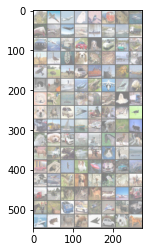

In [ ]:
# Get some random training images to see if trainloader is correct
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(' '.join('%5s' % get_class_name(labels[j]) for j in range(batch_size)))
print(images.shape)
imshow(torchvision.utils.make_grid(images))


# Build model & training

In [ ]:
# Set training params
from_epoch = 0
to_epoch = 300
save_per = 10
learning_rate = 0.01  # 0.001
momentum = 0.9  # 0.9
net = ResNet(layer_cnts=[1, 1, 1, 1], class_cnt=10)


In [ ]:
# Load checkpoint if necessary
if from_epoch > 0:
    PATH = f'{CKPT_DIR}/cifar_resnet_{from_epoch}.pth'
    net.load_state_dict(torch.load(PATH))
    print('Load checkpoint from', PATH)

# Put network onto device
net.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)


Load checkpoint from /content/drive/MyDrive/PR_hw5/checkpoints_tmp/cifar_resnet_10.pth


In [ ]:
# Training
print(f'Start training from epoch {from_epoch} to {to_epoch}')
print(f'lr = {learning_rate}')

for epoch in range(from_epoch, to_epoch):
    running_loss = torch.tensor(0.0).to(device)

    for i, data in enumerate(trainloader, 0):
        # Put inputs and labels onto device
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    # Print statistics
    print(f'Epoch {epoch + 1} loss: {running_loss / len(trainloader)}')
    running_loss = torch.tensor(0.0).to(device)

    if (epoch + 1) % save_per == 0:
        # Save the checkpoint and test
        PATH = f'{CKPT_DIR}/cifar_resnet_{epoch + 1}.pth'
        torch.save(net.state_dict(), PATH)
        y_pred = net.predict(x_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'Epoch {epoch + 1} saved. Test data acc: {acc}')

print('Finished Training')


# Testing

In [ ]:
# Testing
# Set testing params
CKPT_DIR = '/content/drive/MyDrive/PR_hw5/checkpoints_RELEASE'
checkpoint_name = 'cifar_resnet_1_1_1_1_RELEASE_8309'
net = ResNet(layer_cnts=[1, 1, 1, 1], class_cnt=10)

# Load the checkpoint
PATH = f'{CKPT_DIR}/{checkpoint_name}.pth'
net.load_state_dict(torch.load(PATH))
print('Load checkpoint from', PATH)

# Put the net onto device
net.to(device)


# DO NOT MODIFY CODE BELOW!
Please screen shot your results and post it on your report

In [ ]:
y_pred = net.predict(x_test)

In [ ]:
assert y_pred.shape == (10000,)

In [ ]:
y_test = np.load("y_test.npy")
print("Accuracy of my model on test set: ", accuracy_score(y_test, y_pred))

Accuracy of my model on test set:  0.8309
